**This notebook loads Argo profile pairs co-located with tropical cyclones and make plots to explore what happens to the upper ocean as the tropical cyclone passes over the ocean. A profile pair comprises one profile before the cyclone, one after. Pairs are co-located using Hu et al, 2021 (using the same code as in Sala et al, 2021).**

Import statements

In [1]:
import pandas as pd
import numpy as np
import numpy.matlib 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import requests
from calendar import monthrange

from utilities import *

These parameters "need" to be modified

In [2]:
path_fig = '/Users/dgiglio/Downloads/Figures/'

These parameters may be modified, if of interest

In [3]:
# set pressure limits for the plots
pres_lim   = [10,200]

min_TCwind = 64 #0 (to keep only pairs co-located with TC that have wind >=64 knots) # if equal to zero, all the pairs are kept
var2use = 'psal' #'temp' #'chla' # 'doxy' #

pair2TC_angle_max = 0.25 #the smaller the angle, the close (to the TC) the pair needs to be to be considered

These parameters likely don't need modification for now (unless the input file is created with different pressure levels)

Define a few variables based on input parameters

In [135]:
# file to use (pairs for different ocean properties are stored in different files)

if var2use == 'chla':
    path_file= '/Users/dgiglio/Work/DATA/TC_proj_JS_Salinity2020/bgc_TCpairs/'
    fname = path_file+"HurricaneAdjRawVariableDF_noQC.pkl"#"HurricaneAdjRawVariableDF_qcto3.pkl"#
    #fname = "/Users/dgiglio/Work/DATA/TC_proj_JS_Salinity2020/bgc_TCpairs/HurricaneAdjRawVariableDF_qcto2.pkl"
    # set the label for the variable in the input file
    var_lab = 'Chlorophyll a, mg/m3'
    # set pressure axis for the profiles in the input file
    pres       = np.arange(10,212,2)
    plot_flag  = True
elif var2use == 'doxy':
    path_file= '/Users/dgiglio/Work/DATA/TC_proj_JS_Salinity2020/bgc_TCpairs/'
    fname = path_file+"HurricaneAdjRawVariableDF_doxy.pkl"
    var_lab = 'Dissolved Oxygen, micromole/kg'
    # set pressure axis for the profiles in the input file
    pres       = np.arange(10,212,2)
    plot_flag  = True
elif var2use == 'temp':
    path_file= '/Users/dgiglio/Work/DATA/TC_proj_JS_Salinity2020/TS_TCpairs/'
    fname = path_file+"HurricaneAdjRawVariableDF_TEMPERATURE.pkl"
    var_lab = 'Temperature, degC'
    # set pressure axis for the profiles in the input file
    pres       = np.arange(10,212,10)
    plot_flag  = False
    delta = 0.1
    hist_edges  = np.arange(-10,10,delta)
    hist_bins = np.arange(-10+(delta/2),10,delta)
    pres_max_incr = 210 # do not change
elif var2use == 'psal':
    path_file= '/Users/dgiglio/Work/DATA/TC_proj_JS_Salinity2020/TS_TCpairs/'
    fname = path_file+"HurricaneAdjRawVariableDF_SALINITY.pkl"
    var_lab = 'Salinity, psu'
    # set pressure axis for the profiles in the input file
    pres       = np.arange(10,210,5)
    plot_flag  = False
    delta = 0.05
    hist_edges  = np.arange(-5,5,delta)
    hist_bins = np.arange(-5+(delta/2),5,delta)
    pres_max_incr = 210 # do not change

Read in the data and check what is in the dataframe. **Question for Jacopo: which variable is the time difference between the two profiles?**

In [5]:
df = pd.read_pickle(fname)
df.reset_index(drop=True);
df.keys()

Index(['before_pid', 'before_t', 'after_pid', 'after_t', 'angle', 'wind',
       'proj_t', 'sign', 'argo_lat', 'argo_lon', 'HurricaneID', 'profile_dt',
       'hurricane_dt', 'signed_angle', 'adj_before_variable',
       'adj_after_variable', 'raw_before_variable', 'raw_after_variable',
       'standard_signed_angle', 'hurricane_dtd', 'profile_dtd',
       'hurricane_id'],
      dtype='object')

In [6]:
print(np.shape(df))
# df

(17455, 22)


Store some of the variables in the dataframe, to use in the notebook.

In [7]:
raw_before_data     = df.raw_before_variable.reset_index(drop=True)
raw_after_data      = df.raw_after_variable.reset_index(drop=True)
raw_before_data_pid = df.before_pid.reset_index(drop=True)
raw_after_data_pid  = df.after_pid.reset_index(drop=True)
HurricaneID         = df.HurricaneID.reset_index(drop=True)
TC_wind             = df.wind.reset_index(drop=True)
TC_date             = df.proj_t.reset_index(drop=True)
pair2TC_angle       = df.signed_angle.reset_index(drop=True)
argo_lat            = df.argo_lat.reset_index(drop=True).to_numpy()
argo_lon            = df.argo_lon.reset_index(drop=True).to_numpy()

**Plot all the pairs, one per figure (including TS and QC flags for each variable). The legend for the temperature plot includes the time of the tropical cyclone and this information can be leveraged to produce relevant maps using the other notebook we discussed. For each pair, also save the difference between the profiles after the TC and the profile before. Let's also save the pressure at which we see a max and the value of the max both before and after the cyclone.**

In [8]:
# total number of pairs
len(TC_wind)

17455

In [9]:
# number of hurricane strength pairs
sum(TC_wind>64)

4693

In [10]:
sum(abs(pair2TC_angle)<=pair2TC_angle_max)

570

In [56]:
font_size = 22
after_minus_before = []
val_of_max_after   = []
pres_of_max_after  = []
val_of_max_before  = []
pres_of_max_before = []
val_at_shallowest_lev_before = []
val_at_shallowest_lev_after = []
val_at_50dbar_before = []
val_at_50dbar_after = []
max_val_in_top_10lev_before = []
max_val_in_top_10lev_after  = []
raw_before_data_minus_shallow = []
raw_before_data_minus_shallow_hist = []
raw_after_data_minus_shallow = []
raw_before_data_minus_shallow_ppoints_incr = []

for (b,a,b_pid,a_pid,tcID,tcWind,tcDate,p2t_angle) in zip(raw_before_data,raw_after_data,raw_before_data_pid,raw_after_data_pid,HurricaneID,TC_wind,TC_date,pair2TC_angle):
    # save wmo and cycle number
    [b_wmo,b_cyln] = b_pid.split("_")
    b_wmo  = b_wmo.lstrip("0")
    b_cyln = b_cyln.lstrip("0")
    [a_wmo,a_cyln] = a_pid.split("_")
    a_wmo  = a_wmo.lstrip("0")
    a_cyln = a_cyln.lstrip("0")
    
    if plot_flag:
        b_TS    = get_profile(b_wmo+'_'+b_cyln)
        a_TS    = get_profile(a_wmo+'_'+a_cyln)
        
#   ####
    if plot_flag and b_TS is not None and a_TS is not None and tcWind>=min_TCwind and abs(p2t_angle)<=pair2TC_angle_max:
        b_TS_df = parse_1prof_into_df(b_TS,data_type='bgc') 
        a_TS_df = parse_1prof_into_df(a_TS,data_type='bgc') 
        
        print('+++++++++++++++ '+"Tropical Cyclone ID: "+tcID+' +++++++++++++++')
        # plot a map
        num_days = monthrange(int(str(tcDate)[0:4]), int(str(tcDate)[5:7]))[1]
        TCs_loop = TC_and_storms_view(startDate=str(tcDate)[0:8]+'01',
                                      endDate=str(tcDate)[0:8]+f'{num_days:02}',
                                      tag_TC_or_SH_FILT='TC',create_figure=False)
        for x in TCs_loop:
            if x['_id'][0:len(tcID)]==tcID:
                print(x['_id'][0:len(tcID)])
                df = pd.DataFrame(x['traj_data'])
                fig = map_TC(df,dx_buffer = 10,dy_buffer = 10,font_size=font_size)
                plt.plot(b_TS['lon'],b_TS['lat'],'*',color='k',markersize=10)
                plt.plot(a_TS['lon'],a_TS['lat'],'*',color='red',markersize=10)
                plt.title("Tropical Cyclone ID: "+tcID+' (b'+b_wmo+'_'+b_cyln+', a'+a_wmo+'_'+a_cyln+')',fontsize=font_size)
                plt.show()
                fig.savefig(path_fig+var2use+'_'+tcID+'_b'+b_wmo+'_'+b_cyln+'_a'+a_wmo+'_'+a_cyln+'_map.png')    
                      
        # make figure
        font_size=20
        fig = plt.figure(figsize=(7.5*5,7.5))
        # bgc var
        plt.subplot(131)
        make_plot(b=b,a=a,b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag=var_lab,b_yax=pres,a_yax=pres,y_tag='Pressure, dbar',
                  y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)",font_size=font_size)

        # save and plot the pressure of the max value
        xl = plt.xlim();
        val_of_max_before.append(b.max())
        pres_of_max_before.append(pres[b.argmax()])
        plt.plot(xl,[pres[b.argmax()],pres[b.argmax()]],color='k',linestyle='--')

        val_of_max_after.append(a.max())
        pres_of_max_after.append(pres[a.argmax()])
        plt.plot(xl,[pres[a.argmax()],pres[a.argmax()]],color='r',linestyle=':')

        plt.xlim(xl)
        # temperature
        plt.subplot(132)
        make_plot(b=b_TS_df['temp'],a=a_TS_df['temp'],b_tag=list(set(b_TS_df['date']))[0][0:16],
                  a_tag=list(set(a_TS_df['date']))[0][0:16],x_tag='Temperature, degC',
                  b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',
                  y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)",
                  font_size=font_size)
        # salinity
        plt.subplot(133)
        make_plot(b=b_TS_df['psal'],a=a_TS_df['psal'],
                  b_tag="lon: "+"%6.2f" % list(set(b_TS_df['lon']))[0]+", lat: "+"%6.2f" % list(set(b_TS_df['lat']))[0],
                  a_tag="lon: "+"%6.2f" % list(set(a_TS_df['lon']))[0]+", lat: "+"%6.2f" % list(set(a_TS_df['lat']))[0],
                  x_tag='Salinity, psu',
                  b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',
                  y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)",font_size=font_size)

        plt.show()
        fig.savefig(path_fig+var2use+'_'+tcID+'_b'+b_wmo+'_'+b_cyln+'_a'+a_wmo+'_'+a_cyln+'_meas.png')
    
        # make figure with QC flags
        if var2use+'_qc' in b_TS_df and var2use+'_qc' in a_TS_df:
            fig = plt.figure(figsize=(7.5*5,7.5))
            # bgc var
            plt.subplot(131)
            make_plot(b=b_TS_df[var2use+'_qc'],a=a_TS_df[var2use+'_qc'],
                      b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag=var2use+' QC flag',
                      b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',y_lim=pres_lim,
                      title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)",font_size=font_size)
            # temperature
            plt.subplot(132)
            make_plot(b=b_TS_df['temp_qc'],a=a_TS_df['temp_qc'],
                      b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag='Temperature QC flag',b_yax=b_TS_df['pres'],
                      a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',y_lim=pres_lim,
                      title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)",font_size=font_size)
            # salinity
            plt.subplot(133)
            make_plot(b=b_TS_df['psal_qc'],a=a_TS_df['psal_qc'],
                      b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag='Salinity QC flag',
                      b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',
                      y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)",font_size=font_size)

            plt.show()
            fig.savefig(path_fig+var2use+'_'+tcID+'_b'+b_wmo+'_'+b_cyln+'_a'+a_wmo+'_'+a_cyln+'_measQC.png')
    # save the after-before difference
    after_minus_before.append([a-b])
    val_at_shallowest_lev_before.append(b[0])
    val_at_shallowest_lev_after.append(a[0])
    val_at_50dbar_before.append(b[pres==50])
    val_at_50dbar_after.append(a[pres==50])
    max_val_in_top_10lev_before.append(max(b[0:9]))
    max_val_in_top_10lev_after.append(max(a[0:9]))
    raw_before_data_minus_shallow.append([b-b[0]])
    raw_before_data_minus_shallow_hist.append(np.histogram([b-b[0]],bins=hist_edges)[0])
    raw_before_data_minus_shallow_ppoints_incr.append(sum(np.logical_and(b-b[0]>0,pres<pres_max_incr))/len(b)*100)
    raw_after_data_minus_shallow.append([a-a[0]])

In [129]:
# number of hurricane strength with 
sum(np.logical_and(np.squeeze(np.array(val_at_50dbar_before))-np.squeeze(np.array(val_at_shallowest_lev_before))>0,TC_wind>min_TCwind))

3713

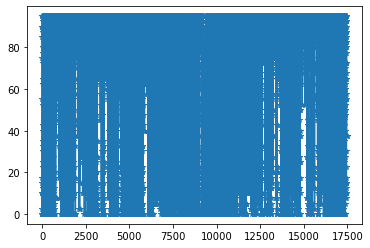

In [54]:
plt.plot(raw_before_data_minus_shallow_ppoints_incr,marker='*')

In [47]:
sum(np.logical_and(b-b[0]>0,pres<pres_max_incr))

15

In [65]:
raw_before_data_minus_shallow = np.squeeze(raw_before_data_minus_shallow)
np.shape(raw_before_data_minus_shallow)

(17455, 40)

In [ ]:
# np.shape(raw_before_data_minus_shallow_hist)

In [ ]:
# plt.imshow(raw_before_data_minus_shallow_hist, interpolation='none',extent=[0,1,0,1])
# plt.show()

In [ ]:
# plt.pcolor(hist_bins,np.arange(0,np.shape(raw_before_data_minus_shallow_hist)[0],1),raw_before_data_minus_shallow_hist)
# plt.colorbar()
# plt.show()

In [ ]:
# plt.pcolor(pres,np.arange(0,np.shape(raw_before_data_minus_shallow_hist)[0],1),raw_before_data_minus_shallow)
# plt.colorbar()
# plt.show()

In [104]:
# number of hurricane strength pairs
sum(np.array(TC_wind>min_TCwind))

4693

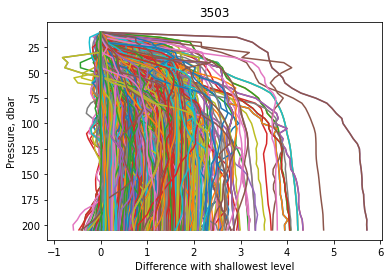

In [132]:
ppoints_incr_min = 75
plt.plot(np.array(raw_before_data_minus_shallow).T
         [:,np.logical_and(np.array(raw_before_data_minus_shallow_ppoints_incr)>=ppoints_incr_min,np.array(TC_wind>min_TCwind))]
         .tolist(),pres)
plt.gca().invert_yaxis()
plt.title(str(sum(np.logical_and(np.array(raw_before_data_minus_shallow_ppoints_incr)>=ppoints_incr_min,np.array(TC_wind>min_TCwind)))))
plt.xlabel('Difference with shallowest level')
plt.ylabel('Pressure, dbar')
plt.show()

In [133]:
# for (x,x_ppoints_incr) in zip(raw_before_data_minus_shallow,raw_before_data_minus_shallow_ppoints_incr):
#     if x_ppoints_incr<ppoints_incr_min:
#         plt.plot(np.squeeze(x),pres)
#         plt.gca().invert_yaxis()
# plt.show()

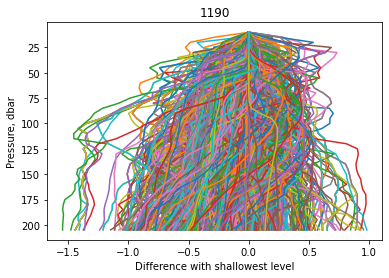

In [134]:
plt.plot(np.array(raw_before_data_minus_shallow).T[:,np.logical_and(np.array(raw_before_data_minus_shallow_ppoints_incr)<ppoints_incr_min,np.array(TC_wind>min_TCwind))].tolist(),pres)
plt.gca().invert_yaxis()
plt.title(str(sum(np.logical_and(np.array(raw_before_data_minus_shallow_ppoints_incr)<ppoints_incr_min,np.array(TC_wind>min_TCwind)))))
plt.xlabel('Difference with shallowest level')
plt.ylabel('Pressure, dbar')
plt.show()

# **LET'S STOP HERE FOR NOW**

Let's edit the dimensions of the variable "after_minus_before" and create a variable that tells pressure for each point in "after_minus_before".

In [ ]:
after_minus_before = np.squeeze(after_minus_before)

# print what the new dimensions are
print(np.shape(after_minus_before))
# create after_minus_before_pres that can tell the pressure for each point in "after_minus_before"
after_minus_before_pres = np.matlib.repmat(pres,np.shape(after_minus_before)[0],1)

Let's now plot the difference between the profile after versus before

In [ ]:
fig = plt.figure(figsize=(15,7.5))
for i in np.arange(0,len(after_minus_before),1):
    plt.plot(after_minus_before[i],pres,marker='*',color='gray')
    
plt.title("Upper ocean changes as the tropical cyclone passes over the ocean",fontsize=font_size)
plt.gca().set_xlabel(var_lab,fontsize=font_size)
plt.gca().set_ylabel('Pressure, dbar',fontsize=font_size)
plt.ylim([10,100])
plt.gca().invert_yaxis()
    
for tick in plt.gca().xaxis.get_majorticklabels():  # example for xaxis
    tick.set_fontsize(font_size) 
for tick in plt.gca().yaxis.get_majorticklabels():  # example for xaxis
    tick.set_fontsize(font_size) 
plt.show()

**Let's make a 2D histogram of the differences, as from the previous plot, it is not very easy to see what happens for most pairs.**

In [ ]:
fig = plt.figure(figsize=(15,7.5))
plt.hist2d(after_minus_before.flatten(), after_minus_before_pres.flatten(), bins=(np.arange(-10,11,1),np.arange(10,100,2))) # , norm=LogNorm()
plt.colorbar()
plt.title("2D histogram",fontsize=font_size)
plt.gca().set_xlabel("Changes in "+var_lab,fontsize=font_size)
plt.gca().set_ylabel('Pressure, dbar',fontsize=font_size)
plt.ylim([10,100])
plt.gca().invert_yaxis()
    
for tick in plt.gca().xaxis.get_majorticklabels():  # example for xaxis
    tick.set_fontsize(font_size) 
for tick in plt.gca().yaxis.get_majorticklabels():  # example for xaxis
    tick.set_fontsize(font_size) 
plt.show()

**How can we summarize better what happens? Let's try and use the max value and the pressure at which this max value is found.**

In [ ]:
# let's define a function to plot an histogram
def plot_histogram(x,delta_bins,xlab='x',xlim=[],font_size=font_size):
    fig = plt.figure(figsize=(15,7.5))
    bins = np.arange(np.floor(min(x)),np.ceil(max(x)),delta_bins)
    plt.hist(x, bins, alpha=0.5, label=xlab)
    
    plt.gca().set_xlabel(xlab,fontsize=font_size)
    if xlim:
        plt.xlim(xlim)
    for tick in plt.gca().xaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(font_size) 
    for tick in plt.gca().yaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(font_size) 
    plt.grid()
    plt.show()
# let's define a function to make a versus plot
def plot_versus(x,y,xlab='x',ylab='y',xlim=[]):
    fig = plt.figure(figsize=(15,7.5))
    plt.plot(x,y,marker='*',linestyle='',markersize=10)
    plt.gca().set_xlabel(xlab,fontsize=font_size)
    plt.gca().set_ylabel(ylab,fontsize=font_size)
    if xlim:
        plt.xlim(xlim)
    for tick in plt.gca().xaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(font_size) 
    for tick in plt.gca().yaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(font_size) 
    plt.grid()
    plt.show()

In [ ]:
plot_histogram(x=np.array(val_of_max_after)-np.array(val_of_max_before),
               delta_bins=0.5,xlab="Difference in upper ocean maximum of "+var_lab)
plot_histogram(x=np.array(val_of_max_after)-np.array(val_of_max_before),
               delta_bins=0.5,xlab="Difference in upper ocean maximum of "+var_lab,xlim=[-5,5])

plot_histogram(x=np.array(pres_of_max_after)-np.array(pres_of_max_before),
               delta_bins=2,xlab='Pressure change (dbar) for upper ocean maximum value of '+var_lab)

plot_versus(x=np.array(val_of_max_after)-np.array(val_of_max_before),y=TC_wind,
            xlab="Difference in upper ocean maximum of "+var_lab,ylab='Tropical cyclone wind, knots')
plot_versus(x=np.array(val_of_max_after)-np.array(val_of_max_before),y=TC_wind,
            xlab="Difference in upper ocean maximum of "+var_lab,ylab='Tropical cyclone wind, knots',xlim=[-3,5])

plot_versus(x=np.array(pres_of_max_after)-np.array(pres_of_max_before),y=TC_wind,
            xlab='Pressure change (dbar) for upper ocean maximum value of '+var_lab,ylab='Wind, knots')

Suggestions for next steps: 
- edit to save figures with suitable file names
- look at what happens at a level of interest and/or the average in a pressure range and/or max in a pressure range
- use the difference in time between profiles to better understand differences in different pairs?
- look at other variables and data with better QC and see if there are enough profile pairs co-located with TCs?

In [ ]:
plot_histogram(x=np.array(val_at_shallowest_lev_after)-np.array(val_at_shallowest_lev_before),
               delta_bins=1,xlab='Difference at 10 dbar for '+var_lab)

plot_versus(x=np.array(val_at_shallowest_lev_after)-np.array(val_at_shallowest_lev_before),y=TC_wind,
            xlab="Difference at 10 dbar for "+var_lab,ylab='Tropical cyclone wind, knots')
plot_versus(x=np.array(val_at_shallowest_lev_after)-np.array(val_at_shallowest_lev_before),y=TC_wind,
            xlab="Difference at 10 dbar for "+var_lab,ylab='Tropical cyclone wind, knots',xlim=[-5,5])

plot_histogram(x=np.array(max_val_in_top_10lev_after)-np.array(max_val_in_top_10lev_before),
               delta_bins=1,xlab='Difference in max value of top 10 levels for '+var_lab)

plot_versus(x=np.array(max_val_in_top_10lev_after)-np.array(max_val_in_top_10lev_before),y=TC_wind,
            xlab='Difference in max value of top 10 levels for '+var_lab,ylab='Tropical cyclone wind, knots')
plot_versus(x=np.array(max_val_in_top_10lev_after)-np.array(max_val_in_top_10lev_before),y=TC_wind,
            xlab='Difference in max value of top 10 levels for '+var_lab,ylab='Tropical cyclone wind, knots',xlim=[-5,5])